# Visualizing Soccer Data

#### Citations:

@Article{Hunter:2007,
  Author    = {Hunter, J. D.},
  Title     = {Matplotlib: A 2D graphics environment},
  Journal   = {Computing In Science \& Engineering},
  Volume    = {9},
  Number    = {3},
  Pages     = {90--95},
  abstract  = {Matplotlib is a 2D graphics package used for Python
  for application development, interactive scripting, and
  publication-quality image generation across user
  interfaces and operating systems.},
  publisher = {IEEE COMPUTER SOC},
  doi       = {10.1109/MCSE.2007.55},
  year      = 2007
}

#### Imports

In [1]:
import json
import math
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random
from statsmodels.stats.proportion import proportions_ztest

#### Defines a soccer game

In [2]:
class Game:
    def __init__(self, homeTeam, awayTeam, homeScore, awayScore, date):
        self.homeTeam = homeTeam
        self.awayTeam = awayTeam
        self.homeScore = homeScore
        self.awayScore = awayScore
        self.date = date
        
        
    # Displays a game in the format Liverpool 4-3 Manchester City
    def display(self):
        print(self.homeTeam + " " + str(self.homeScore) + "-" +
             str(self.awayScore)+" "+self.awayTeam) 

#### Defines one matchday

In [3]:
class Matchday:
    def __init__(self, number):
        self.number = number
        self.games = []
        
        
    # Adds a game to the list of games
    def addGame(self, game):
        self.games.append(game)

#### Defines a team's general stats over one season

In [4]:
class TeamSeason:
    def __init__(self, name):
        self.name = name
        self.points = 0
        self.scored = 0
        self.conceded = 0
        self.gD = 0
        self.place = 0
        
        
    # Adds info from one game to the data on a team's season-long performance
    def addGame(self, game):
        isHomeTeam = game.homeTeam == self.name
        
        # Assigning points for a draw
        if game.homeScore == game.awayScore:
            self.points += 1
            
        # Updating variables if home team
        if isHomeTeam:
            if game.homeScore > game.awayScore:
                self.points += 3
            self.scored += game.homeScore
            self.conceded += game.awayScore
        
        # Updating variables if away team
        else:
            if game.homeScore < game.awayScore:
                self.points += 3
            self.scored += game.awayScore
            self.conceded += game.homeScore
        self.gD = self.scored - self.conceded

#### Defines a class for an entire season

In [5]:
class Season:
    def __init__(self, year):
        self.year = year
        # A dictionary in the form of name: TeamSeason object
        self.teams = {}
        self.placed = []
        self.matchDays = []
        
    # adds to a list of individual weeks
    def addMatchDays(self, matchDay):
        self.matchDays.append(matchDay)
        
    # adds a team to the dictionary of teams
    def addTeam(self, name):
        if not name in self.teams:
            self.teams[name] = TeamSeason(name)
            
    # Given two teams, it compares them using official EPL procedures
    # Return 1 if teamA is better than team B, -1 if not
    def compareTeams(self, teamA, teamB):
        if teamA.points > teamB.points:
            return 1
        elif teamA.points == teamB.points:
            if teamA.gD > teamB.gD:
                return 1
            elif teamB.gD == teamB.gD:
                if teamA.scored > teamB.scored:
                    return 1
                elif teamB.scored == teamB.scored:
                    if teamA.name > teamB.name:
                        return 1
                    else:
                        return -1
                else:
                    return -1
            else:
                return -1
        else:
            return -1
        
    # Orders the teams based on comparisons
    def place(self):
        for team in self.teams:
            for i in range(len(self.teams)):
                try:
                    if self.compareTeams(self.teams[team], self.placed[i]) > 0:
                        self.placed.insert(i, self.teams[team])
                        break
                except IndexError:
                    self.placed.append(self.teams[team])
                    break
        for i in range(len(self.teams)):
            self.placed[i].place = i+1
            
    # Prints a simple epl table
    def table(self):
        for i in range(len(self.teams)):
            try:
                print(str(i+1) + " " + self.placed[i].name)
            except IndexError:
                print("Not Yet")

#### Creates arrays of seasons for four different leagues over several seasons

In [6]:
# Function that, when given Matchday 12 or 3-Matchday, or something like that, will return 12 or 3
def extractNumbers(matchdayName):
    numString = ""
    for i in matchdayName:
        try:
            numString += str(int(i))
        except ValueError:
            x = 1
    try:
        return int(numString)
    except ValueError:
        return 0


# Function to create a new season based on a json file
def newSeason(fileName):
    # Open data from file
    with open(fileName, "r") as read_file:
        data = json.load(read_file)
    # Name the new season:
    season = Season(data['name'])
    
    # Iterating through all sets of games
    for matchDay in data['rounds']:
        # Creating a matchday object
        if extractNumbers(matchDay['name']) == 0:
            break
        oneRound = Matchday(extractNumbers(matchDay['name']))
        # Iterating through each match
        for match in matchDay["matches"]:
            # On the first round, record the team names
            if oneRound.number == 1:
                season.addTeam(match['team1']['name'])
                season.addTeam(match['team2']['name'])
            # Attempt to create game object and add it to teamSeasons and one round
            try:
                game = Game(match['team1']['name'], match['team2']['name'],
                            int(match['score1']), int(match['score2']), match['date'])
                oneRound.addGame(game)
                season.teams[game.homeTeam].addGame(game)
                season.teams[game.awayTeam].addGame(game)
            # TypeError occurs when game was cancelled and scores are null
            except TypeError:
                x = 1
        # Adding a round of matches to the season
        season.addMatchDays(oneRound)
    # Determine final places in a season
    season.place()
    return season


# Function to create a list of seasons for each country
def makeSeasons(startYear, endYear, country):
    seasons = []
    for i in range(endYear - startYear):
        seasonName = "data/" + str(startYear+i) + "-" + str(startYear+i+1)[-2:] + "/" + country + ".1.json"
        season = newSeason(seasonName)
        seasons.append(season)
    return seasons

# Taking all possible data from the different leagues
eng = makeSeasons(2012, 2017, "en")
spn = makeSeasons(2012, 2017, "es")
ity = makeSeasons(2013, 2017, "it")
deu = makeSeasons(2012, 2017, "de")
aus = makeSeasons(2012, 2017, "at")

# Making a dictionary combining the data
leagues = {"England": eng, "Espana": spn, "Italia": ity,
           "deutschland": deu, "Osterreich": aus}

#### Define functions to visualize data

In [7]:
# Function taking in a list of seasons, outputting final place vs goals scored
def plotScoredPlace(seasons):
    scored = []
    finalPlace = []
    for season in seasons:
        for key, team in season.teams.items():
            scored.append(team.scored)
            finalPlace.append(team.place)
    plt.scatter(scored,finalPlace)
    plt.xlabel("Goals Scored")
    plt.ylabel("Final Position")
    slope, intercept, r_value, p_value, std_err = stats.linregress(scored,finalPlace)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(scored,finalPlace, 'yo', scored, fit_fn(scored), '--k')
    plt.title('Table 3')
    

# Function taking in a list of seasons, outputting final place vs log(goals scored)
def plotScoredPlaceLog(seasons):
    scored = []
    scored1 = []
    finalPlace = []
    for season in seasons:
        for key, team in season.teams.items():
            scored.append(math.log(team.scored, math.e))
            scored1.append(team.scored)
            finalPlace.append(team.place)
    scored = stats.zscore(scored)
    plt.scatter(scored,finalPlace)
    plt.xlabel("Natural Log of Goals Scored")
    plt.ylabel("Final Position")
    slope, intercept, r_value, p_value, std_err = stats.linregress(scored,finalPlace)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(scored,finalPlace, 'yo', scored, fit_fn(scored), '--k')
    plt.title('Table 5')
    return r_value**2

    
# Function taking in a list of seasons, outputting final place vs goals conceded
def plotConcededPlace(seasons):
    conceded = []
    finalPlace = []
    for season in seasons:
        for key, team in season.teams.items():
            conceded.append(team.conceded)
            finalPlace.append(team.place)
    plt.scatter(conceded,finalPlace, color="red")
    plt.xlabel("Goals Conceded")
    plt.ylabel("Final Position")
    plt.title('Table 3')
    slope, intercept, r_value, p_value, std_err = stats.linregress(conceded,finalPlace)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(conceded,finalPlace, 'yo', conceded, fit_fn(conceded), '--k')
    return r_value**2


# Function taking in a list of seasons and outputting the number of goals conceded vs. the number scored
def plotConcededScored(seasons):
    conceded = []
    scored = []
    for season in seasons:
        for key, team in season.teams.items():
            conceded.append(math.log(team.conceded, math.e))
            scored.append(team.scored)
    plt.scatter(conceded,scored,color="blue")
    plt.xlabel("Goals Conceded")
    plt.ylabel("Goals Scored")
    plt.title('Table 1')
    slope, intercept, r_value, p_value, std_err = stats.linregress(conceded,scored)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(conceded,scored, 'yo', conceded, fit_fn(conceded), '--k')
    
# Displays the difference between home wins and away wins
def plotHomeWins(seasons):
    homeWins = 0
    awayWins = 0
    draws = 0
    total = 0
    for season in seasons:
        for matchday in season.matchDays:
            for game in matchday.games:
                if game.homeScore > game.awayScore:
                    homeWins += 1
                elif game.homeScore < game.awayScore:
                    awayWins += 1
                else:
                    draws += 1
                total += 1
    homePercentage = homeWins / total
    awayPercentage = awayWins / total
    drawPercentage = draws/total
    print("Home wins: "+str(homeWins))
    print("Away wins: "+str(awayWins))
    print("Draws: "+str(draws))
    print("Home win proportion: "+str(homePercentage))
    print("Away win proportion: "+str(awayPercentage))
    print("Draw proportion: "+str(drawPercentage))
    x = np.arange(3)
    plt.bar(x, [homePercentage, awayPercentage, drawPercentage])
    plt.xticks(x, ('Home Wins', 'Away Wins', 'Draws'))
    plt.title('Table 1')

def compareRs(leagues):
    scored = []
    conceded = []
    dif = []
    for key, value in leagues.items():
        scored.append(plotScoredPlaceLog(value))
        conceded.append(plotConcededPlace(value))
        dif.append(plotScoredPlaceLog(value)-plotConcededPlace(value))
    print("Scored: "+str(scored))
    print("Conceded: "+str(conceded))
    print(dif)
#compareRs(leagues)
    
            

### Display the difference between home wins and away wins:

Home wins: 3576
Away wins: 2295
Draws: 1879
Home win proportion: 0.46141935483870966
Away win proportion: 0.29612903225806453
Draw proportion: 0.2424516129032258


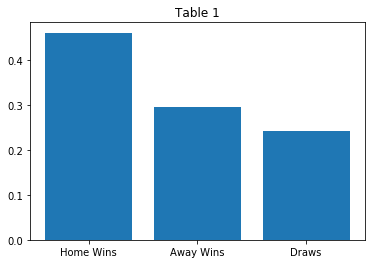

In [19]:
plotHomeWins(eng+spn+ity+deu+aus)

### Plots the number of goals scored against the final league position

LSRL: y = 26.193536465796807 + -0.3029640244362318x
r^2: 0.7320339766378002


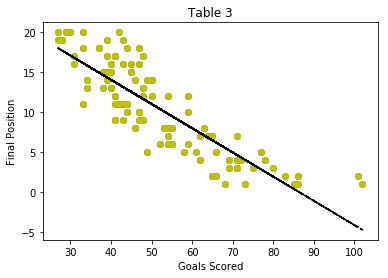

In [20]:
plotScoredPlace(eng)

### Plots log(number of goals scored) against the final league position

LSRL: y = 10.499999999999993 + -5.0246432840420345x
r^2: 0.7593094776501876


0.7593094776501876

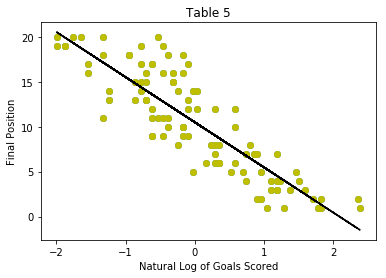

In [21]:
plotScoredPlaceLog(eng)

### Plots the number of goals conceded against the final league position

LSRL: y = -9.56747793527681 + 0.38740304894356775x
r^2: 0.6750716588207613


0.6750716588207613

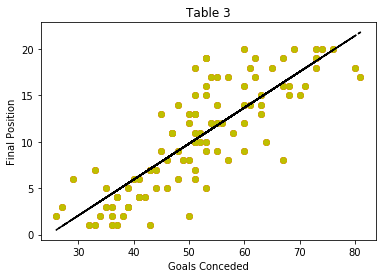

In [22]:
plotConcededPlace(eng)

### Plots the number of goals conceded against the number scored

LSRL: y = 221.0065092477314 + -43.184327637759544x
r^2: 0.42380734742900494


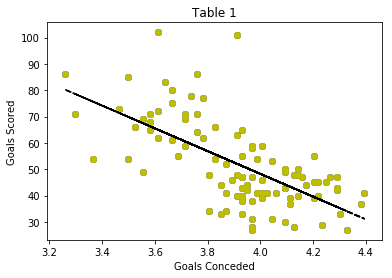

In [12]:
plotConcededScored(eng)

#### Statistical Tests for Home Field Advantage

In [13]:
def oneProportionZTestHomeWinsDraws(seasons):
    prop_total = []
    for season in seasons:
        for matchday in season.matchDays:
            prop_wins = 0
            prop_losses = 0
            day_total = 0
            for game in matchday.games:
                if game.homeScore > game.awayScore:
                    prop_wins += 1
                elif game.homeScore < game.awayScore:
                    prop_losses += 1
                day_total += 1
            prop_wins = prop_wins / day_total
            prop_losses = prop_losses / day_total
            prop_dif = prop_wins - prop_losses
            prop_total.append(prop_dif)
            
    # In case someone from Facebook is looking over this, I did make a mistake in my writeup of this project by stating that I used a z test when I here used a t test
    t, prob = stats.ttest_1samp(prop_total, 0, axis=None)
    print("T value: "+str(t)+"\nP-val: "+str(prob))


oneProportionZTestHomeWinsDraws(eng+spn+ity+deu+aus)

T value: 16.674728549046293
P-val: 1.8332546985506983e-54


### K-Means Clustering with Final Position
##### Here I wanted to experiment with a k-means clustering algorithm, so I used that process to split the final league table into a top and bottom group. This tturned out to be fairly interesting as some leagues such as La Liga and the German Bundesliga seem to consistently have a small group of clubs near the top, other leagues such as the Austrian Bundesliga are more evenly distributed.

In [18]:
def get_mean(teams):
    mean = 0
    for team in teams:
        mean += team.points
    return mean / len(teams)

def k_means_clustering(season):
    teams = []
    for team_name, team in season.teams.items():
        teams.append(team)
    group1 = teams[:10]
    group2 = teams[-10:]
    while True:
        changes = 0
        average1 = get_mean(group1)
        average2 = get_mean(group2)
        for team in group1:
            if abs(team.points - average2) < abs(team.points - average1):
                changes += 1
                group1.remove(team)
                group2.append(team)
        for team in group2:
            if abs(team.points - average2) > abs(team.points - average1):
                changes += 1
                group2.remove(team)
                group1.append(team)
        if changes == 0:
            break
    if get_mean(group1) > get_mean(group2):
        return group1, group2
    else:
        return group2, group1
        
def display_groups(group1, group2):
    print("Top Group:")
    for team in group1:
        print(team.name)
    print("\nBottom Group:")
    for team in group2:
        print(team.name)

while True:
    print("League Options: ")
    print(" 1. English Premier League\n 2. La Liga\n 3. German Bundesliga\n 4. Serie A\n 5. Austrian Bundesliga")
    league = input("Choose the number of a league: ")
    try:
        if int(league) > 0 and int(league) < 6:
            print("\n\n")
            break
        else:
            print("Invalid number.\n")
    except ValueError:
        print("Please type a number\n")
options = [eng, spn, deu, ity, aus]
league1 = options[int(league) - 1]

while True:    
    print("Year Options:")
    if not league == "4":
        print(" 0. 2012-13")
    print(" 1. 2013-14\n 2. 2014-15\n 3. 2015-16\n 4. 2016-17\n ")
    year = input("Choose the number of a year: ")
    try:
        if (int(year) >= 0 and int(year) < 5 and league != "4") or (int(year) > 0 and int(year) < 5):
            print("\n\n")
            break
        else:
            print("Invalid number.\n")
    except ValueError:
        print("Please type a number\n")    
        
year1 = int(year)
if league == "4":
    year1 -= 1

group1, group2 = k_means_clustering(league1[year1])
display_groups(group1, group2)

League Options: 
 1. English Premier League
 2. La Liga
 3. German Bundesliga
 4. Serie A
 5. Austrian Bundesliga
Choose the number of a league: 4



Year Options:
 1. 2013-14
 2. 2014-15
 3. 2015-16
 4. 2016-17
 
Choose the number of a year: 4



Top Group:
Roma
Juventus
Fiorentina
Atalanta
Lazio
Inter
Milan
Napoli

Bottom Group:
Empoli
Sampdoria
Genoa
Cagliari
Torino
Palermo
Sassuolo
Pescara
Udinese
Bologna
Chievo
Crotone


### Shows the proportion of home games won to away games won versus the difference in the two teams' final standings

In [26]:
def plotHomeWinsClose(seasons, dif):
    homeWins = 0
    awayWins = 0
    draws = 0
    total = 0
    for season in seasons:
        for matchday in season.matchDays:
            for game in matchday.games:
                if abs(season.teams[game.homeTeam].place - season.teams[game.awayTeam].place) < dif+1:
                    if game.homeScore > game.awayScore:
                        homeWins += 1
                    elif game.homeScore < game.awayScore:
                        awayWins += 1
                    else:
                        draws += 1
                    total += 1
    homePercentage = homeWins / total
    awayPercentage = awayWins / total
    drawPercentage = draws/total
    print(str(dif) + ":  " + str(homePercentage/awayPercentage))
    return(homePercentage/awayPercentage)

for i in range(19):
    plotHomeWinsClose(eng+spn+ity+deu+aus, i+1)

1:  1.827433628318584
2:  1.7057522123893805
3:  1.7461538461538462
4:  1.7402135231316727
5:  1.7192642787996129
6:  1.6669401148482361
7:  1.6863033873343154
8:  1.6480263157894737
9:  1.6314511232544022
10:  1.619750283768445
11:  1.6055734190782422
12:  1.60306905370844
13:  1.587573385518591
14:  1.5781766650921114
15:  1.5730698529411764
16:  1.5664869721473493
17:  1.561201944321697
18:  1.5579868708971552
19:  1.5581699346405227


### Example of Normal Distribution of Sample Means

SD: 0.031716357357048426


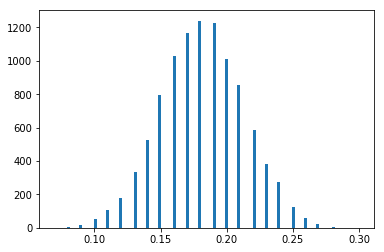

In [29]:
def get_sample(games):
    sample = []
    for i in range(40):
        sample.append(random.choice(games))
    return sample

def get_proportion(sample):
    homeWins = 0
    for game in sample:
        if game.homeScore > game.awayScore:
            homeWins += 1
    return homeWins / 100

def get_samples(seasons, n):
    proportions = []
    # Get list of games
    games = []
    for season in seasons:
        for matchday in season.matchDays:
            for game in matchday.games:
                games.append(game)
    
    for i in range(n):
        proportions.append(get_proportion(get_sample(games)))
    return proportions
    
def plot_samples(proportions, n):
    print("SD: "+ str(np.std(proportions)))
    plt.hist(proportions, bins=n)
    
    
    

plot_samples(get_samples(eng, 10000), 100)

